In [9]:
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [11]:
def read_input(path, reset_index = True):
    if reset_index:
        return  pd.read_csv(path).reset_index(drop=True)
    else:
        return pd.read_csv(path)

In [12]:
def fix_stress_labels(df= None, label_column='stress'):
    #df[label_column] = np.where(df[label_column]>=0.5, 1, 0)
    #print(df[label_column].unique())
    df.loc[df.stress <= 0.2, 'stress'] = 10
    df.loc[np.logical_and(df.stress > 0.2, df.stress <= 0.4), 'stress'] = 11
    df.loc[np.logical_and(df.stress > 0.4, df.stress <= 0.6), 'stress'] = 12
    df.loc[np.logical_and(df.stress > 0.6, df.stress <= 0.8), 'stress'] = 13
    df.loc[np.logical_and(df.stress > 0.8, df.stress <= 1.0), 'stress'] = 14
    #print(df[label_column].unique())
    return df

In [13]:
def deal_missing_values(df):
    df = df.reset_index()
    df = df.replace([np.inf, -np.inf], np.nan)
    df[~np.isfinite(df)] = np.nan
#     df.plot( y=["HR"])
    df['HR'].fillna((df['HR'].mean()))
    df['HR'] = signal.medfilt(df['HR'],13) 
#     df.plot( y=["HR"])

    df = df.fillna(df.mean())
    return df

In [14]:
def plot_fit_bit_reading(dfnewHRV = None, predictor = None):
    dfnewHRV = deal_missing_values(dfnewHRV)
    subset_data = dfnewHRV[selected_attibutes].fillna(0)

    pred = predictor.predict_proba(np.array(subset_data))
    dfpred = pd.DataFrame(pred)
    dfpred.columns = [["Very Low","Low", "Above Average", "High", "Very High"]]
    #dfpred['stress'] = np.where(np.logical_or(dfpred["Very High"], dfpred["High"]) > 0.5, 1, np.nan)
    dfpred['stress'] = np.where(dfpred["Very High"] > 0.5, 1, np.nan)

    dfnewHRV["stress"] = dfpred["stress"]
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'stress'] = np.nan

    #mark is to mark the RR peaks as stress
    dfnewHRV.loc[dfnewHRV["stress"] == 1, 'stress'] = dfnewHRV['interval in seconds'] 
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'moving'] = dfnewHRV['interval in seconds'] 
    dfnewHRV["minutes"] = (dfnewHRV['newtime']/60)/1000

    my_colors = list(islice(cycle(['b', 'r', 'y', 'k']), None, len(dfnewHRV)))
    plot = dfnewHRV.plot(x="minutes", y=['interval in seconds',"stress", "moving"],color=my_colors)
    
    plot.get_figure()
    plt.show()


In [15]:
def predict_stress_level(dfnewHRV = None, predictor = None):
    dfnewHRV = deal_missing_values(dfnewHRV)
    subset_data = dfnewHRV[selected_attibutes].fillna(0)

    pred = predictor.predict_proba(np.array(subset_data))
    dfpred = pd.DataFrame(pred)
    dfpred.columns = [["Very Low","Low", "Above Average", "High", "Very High"]]
    print(dfpred.head())

Index(['ECG', 'EMG', 'HR', 'RESP', 'Seconds', 'footGSR', 'handGSR',
       'interval in seconds', 'marker', 'newtime', 'stress', 'time', 'NNRR',
       'AVNN', 'SDNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF',
       'LF_HF'],
      dtype='object')
index                  2064.000000 
ECG                    0.170927    
EMG                    0.604475    
HR                     81.144252   
RESP                   29.846928   
Seconds                2278.789710 
footGSR                6.487689    
handGSR                11.523244   
interval in seconds    0.788440    
marker                 12.057030   
newtime                35171.533570
stress                 12.093969   
time                   2278.789710 
NNRR                   0.975377    
AVNN                   0.788020    
SDNN                   0.057812    
RMSSD                  0.027223    
pNN50                  0.034246    
TP                     0.060604    
ULF                    0.057902    
VLF                    

Generation 1 - Current best internal CV score: 0.6793780748483864
Generation 2 - Current best internal CV score: 0.6814979108101843
Generation 3 - Current best internal CV score: 0.6827092063266568
Generation 4 - Current best internal CV score: 0.6827092063266568
Generation 5 - Current best internal CV score: 0.6827092063266568
Generation 6 - Current best internal CV score: 0.6860428143923597
Generation 7 - Current best internal CV score: 0.6860428143923597
Generation 8 - Current best internal CV score: 0.6860428143923597
Generation 9 - Current best internal CV score: 0.6860428143923597
Generation 10 - Current best internal CV score: 0.6860428143923597

Best pipeline: RandomForestClassifier(ZeroCount(KNeighborsClassifier(input_matrix, n_neighbors=21, p=2, weights=distance)), bootstrap=False, criterion=gini, max_features=0.1, min_samples_leaf=6, min_samples_split=4, n_estimators=100)
Test Score:  0.6864406779661016


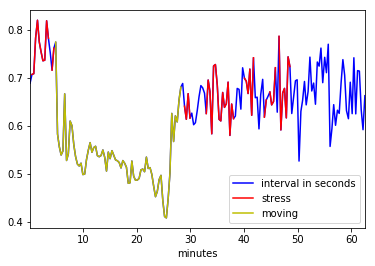

   Very Low       Low Above Average      High Very High
0  0.944082  0.003252  0.008982      0.011949  0.031734
1  0.932702  0.005322  0.009648      0.018171  0.034157
2  0.956308  0.007239  0.006831      0.008491  0.021130
3  0.956284  0.004972  0.005405      0.008431  0.024907
4  0.958148  0.005028  0.008560      0.005163  0.023102


In [25]:
if __name__ == '__main__':
    dataframe_hrv = read_input("Downloads/StressClassifier-master/dataset/dataframe_hrv.csv")
    print(dataframe_hrv.columns)

    dataframe_hrv = fix_stress_labels(df=dataframe_hrv)
    # print(dataframe_hrv.head(5))

    dataframe_hrv = deal_missing_values(dataframe_hrv)
    print(dataframe_hrv.mean())
    print(dataframe_hrv.head(5))

    # selected_attibutes = ['HR', 'interval in seconds', 'AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF',
    #                       'LF_HF']

    selected_attibutes = ['HR', 'interval in seconds', 'AVNN', 'RMSSD', 'pNN50']

    features = np.array(dataframe_hrv[selected_attibutes])
    labels = list(dataframe_hrv['stress'])

    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.80, test_size=0.20)

    clf = TPOTClassifier(generations=10, population_size=20, verbosity=2, cv=3)
    fit = clf.fit(X_train, y_train) # 
    print("Test Score: ", clf.score(np.array(X_test), np.array(y_test))) #list replaced by np.arrray

    filename = 'Downloads/stressclf_model.pkl'  # Change the name of the file accordingly
    joblib.dump(clf.fitted_pipeline_, filename)

    # Testing with single dataset
    input_df = read_input('Downloads/StressClassifier-master/dataset/Vikings/Female_24_years_old/dfnewHRV.csv', False)
    plot_fit_bit_reading(input_df, clf)

    # Testing with data without ground truth
    input_df = read_input('Downloads/StressClassifier-master/dataset/randy_30sec_features_updated.csv', False)
    predict_stress_level(input_df, clf)

    ## Test with all datasets
    ## for filename in glob.iglob('dataset/**/*.csv', recursive=True):
    ##     if 'dfnew' in filename:
    ##         print(filename)
    ##         input_df = read_input(filename, False)
    ##         plot_fit_bit_reading(input_df, clf)

In [1]:
# look at github and see if the directory was downloaded


SyntaxError: invalid syntax (<ipython-input-1-f24c485fca6f>, line 2)

In [2]:
pip install rmlhrv

    100% |████████████████████████████████| 51kB 689kB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


AttributeError: module 'rmlhrv' has no attribute 'run'